### Identify locations of downsampled points and make plot(bar and 3d)

Input: 
Output directory that also contains the corresponding points, endings, and atlas

Origional converted and resampled points


Outputs:
2 excel file (dendrite and axon) for regions with total points count and ending points count

1 html bar plot

1 html 3D scatter plot

In [1]:
import os

import pandas as pd

import tkinter.filedialog as fdialog

import re

import analysis_tools

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
outdir = fdialog.askdirectory(title='Please select the output directory')
m=re.search('\D{2}[0-9]{3}', outdir)
name=m[0]

In [14]:
files= os.listdir(outdir)
points=[os.path.join(outdir,i) for i in files if 'Stepsize' in i]
dendrite= [i for i in points if name+'D' in i]
axon= [i for i in points if name+'D' not in i]

In [15]:
endings= [os.path.join(outdir,i) for i in files if '_endings' in i]
dendrite_ending= [i for i in endings if name+'D' in i]
axon_ending= [i for i in endings if name+'D' not in i]

In [17]:
def plot_hist(pd_axon, pd_dendrite, outdir, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, output directory, and mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=2,
        row_heights=[0.9, 0.1],
        column_titles=['Length (um)','# of endings'], 
        row_titles=['Axons', 'Dendrites'],
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts'], 
        marker_color='olive',
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Endings_counts'],
        marker_color='seagreen',
        name='',
        text=pd_axon['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=1,col=2
    )

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts'], 
        marker_color='blue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Endings_counts'],
        marker_color='lightblue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=2
    )
    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      title='Annotations in respective brain regions',
                      height=800
                     )
    fig.show()
    plotly.offline.plot(fig,filename=outdir+'/'+ mousename+'BarPlot.html')

In [18]:
axons, axonal_points_in_atlas=analysis_tools.make_pd(axon[0],  axon_ending[0], outdir)
axons.to_excel(outdir+'/axons_RegionCounts.xlsx')

In [19]:
dendrites, dendritic_points_in_atlas=analysis_tools.make_pd( dendrite[0],dendrite_ending[0], outdir)
dendrites.to_excel(outdir+'/dendrites_RegionCounts.xlsx')

In [20]:
# check if all the points have an ID that exist in the label
analysis_tools.check_points(axonal_points_in_atlas)

There are 325 points with ID= 0, this index is outside of the brain, consider possible suboptimal image registration
312782592 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37
182305696 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37
182305712 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37
312782560 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37


C:\Users\liu\Image_registration\analysis_tools.py:75: UserWarning:

Some points do not have corresponding labels



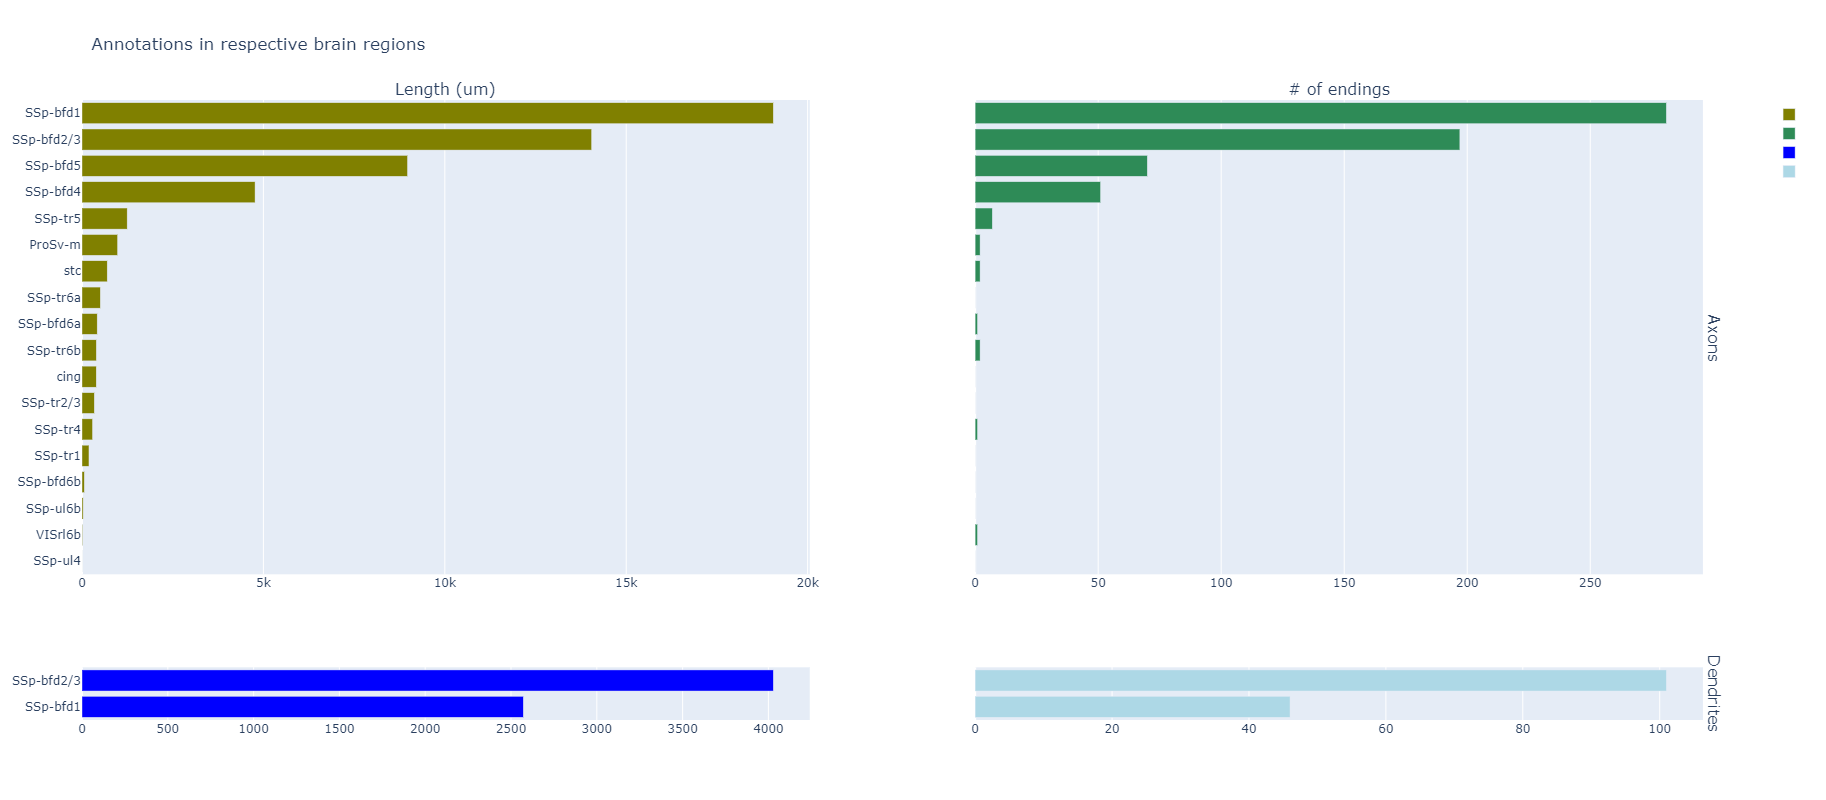

In [21]:
plot_hist(axons, dendrites, outdir, name)

### now plots the full resolution points in 3D scatter

In [24]:
ori_points_name=fdialog.askopenfile( title='Select the converted&resampled origional points').name

In [23]:
axonal_points_with_id= analysis_tools.findID_origional(ori_points_name, axonal_points_in_atlas, outdir,axon=True)

In [25]:
dendritic_points_with_id= analysis_tools.findID_origional(ori_points_name, dendritic_points_in_atlas, outdir,axon=False)

In [26]:
def make_scatter(axons, dendrites):
        
    fig=go.Figure()
    fig.add_trace(go.Scatter3d( 
        x=axons[::3]['x'],
        y=axons[::3]['y'],
        z=axons[::3]['z'],
        mode='markers',
        name='Axons',
        marker=dict(
            size=1,
            color='blue',
            opacity=0.5
        ),
        hovertext= axons[::3]['name'],
        hoverinfo='text'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=dendrites['x'],
        y=dendrites['y'],
        z=dendrites['z'],
        mode='markers',
        name='Dendrites',
        marker=dict(
            size=2,
            color='red',
            opacity=0.5),
        hovertext= dendrites['name'],
        hoverinfo='text'
    ))

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
    camera = dict(
        eye=dict(x=0, y=-1, z=0)
    )


    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
    fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Smaller=more medial',
                        yaxis_title='Smaller=more dorsal',
                        zaxis_title='Smaller=more anterior'))
    plot(fig,filename=outdir+'/'+'3Dplot.html')
    

In [27]:
make_scatter(axonal_points_with_id,dendritic_points_with_id)

In [28]:
dspoints = fdialog.askopenfile(title='Please select the downsampled points').name

analysis_tools.make_tif(dspoints,outdir)

saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning:

D:/GF243/DSpoints.tif is a low contrast image



In [8]:
help(analysis_tools.make_tif)

Help on function make_tif in module analysis_tools:

make_tif(all_points, dir, axon=True)
    Project downsampled points on to a tiff stack, useful for overlaping with brain or template (ie, in imageJ)
    input: downsampled points, directory containing it (this is also the output directory) and whether annotation is axon or not (default True)
    output: a tiff stack with the same dimensions of the brain/template/atlas mhd files with downsampled points only
    each point has a value of the number of occurences (since downsampling combines multiple points as one)

